In [1]:
from darts.models import TFTModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.metrics import rmse
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch

/opt/conda/lib/python3.11/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
df = utils.load_data()

# Create a TimeSeries object
ts = TimeSeries.from_dataframe(df, value_cols=['US_TB_YIELD_10YRS']) #.add_holidays("US")

# Create covariates
covariates = df.drop(columns=['US_TB_YIELD_10YRS'])
covariates = TimeSeries.from_dataframe(covariates)

In [3]:
ts = MissingValuesFiller().transform(ts)
covariates = MissingValuesFiller().transform(covariates)



covariates_scaler = Scaler(StandardScaler())
covariates_scaled = covariates_scaler.fit_transform(covariates)

scaler = Scaler(StandardScaler())
ts_scaled = scaler.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

<Axes: xlabel='DATE'>

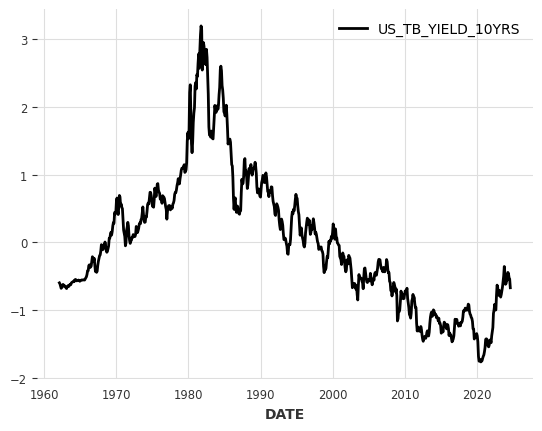

In [4]:
ts_scaled.plot()

In [5]:
input_chunk_length = 12
forecast_horizon = 1
model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=2,
    dropout=0.1,
    batch_size=16,
    n_epochs=2, #300,
    add_relative_index=True,
    add_encoders=None,
    likelihood=QuantileRegression(),  # QuantileRegression is set per default
    loss_fn=torch.nn.MSELoss(),
    optimizer_kwargs={"lr": 1e-5},
    random_state=42,
)

model.fit(series=train_ts_scaled, past_covariates=train_covariates_scaled,
                val_series=val_ts_scaled,
             val_past_covariates = val_covariates_scaled, verbose=True)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0      | train
1  | train_criterion                   | MSELoss                          | 0      | train
2  | val_criterion                     | MSELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelectionNetw

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=MSELoss(), likelihood=QuantileRegression(quantiles: Optional[list[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=12, output_chunk_length=1, batch_size=16, n_epochs=2, add_encoders=None, optimizer_kwargs={'lr': 1e-05}, random_state=42)

In [7]:
model.predict(n=forecast_horizon, series=train_ts_scaled, past_covariates=train_covariates_scaled, num_samples=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (DATE: 1, component: 1, sample: 100)> Size: 400B
array([[[ 0.45599335, -0.01015741, -0.6961424 , -0.19467664,
          0.07122687, -0.45152688, -0.26790342, -0.21587291,
         -0.4869748 , -0.655932  , -0.01539427, -0.48376498,
         -0.8233724 , -0.20767003, -0.31860495, -0.6195153 ,
         -0.5259253 ,  0.12319706, -0.3699704 ,  0.19243583,
         -0.766966  , -0.79802835,  0.16033286, -0.0301079 ,
         -0.21946055, -0.57560873,  0.11997518, -0.6134691 ,
          0.17120358,  0.17409483, -0.7795934 , -0.1471588 ,
          0.07817958,  0.38113236,  0.20398718,  0.0104211 ,
         -0.48523057,  0.05716002, -0.00578851, -0.69025576,
          0.03774922, -0.29580536,  0.11574376, -0.6244342 ,
         -0.7685214 , -0.2080288 , -0.4493171 , -0.58064336,
          0.45599335,  0.10915294, -0.61631733, -0.21845439,
          0.3435374 , -0.47528636, -0.5191462 , -0.51786023,
         -0.1476933 , -0.21956635, -0.21317008,  0.5353987 ,
         -0.15120167,  0.11724578, -0.35413885, -0.4506263 ,
         -0.3892975 , -0.48611993,  0.26149005, -0.2560311 ,
          0.00445837, -0.63661265, -0.12680486, -0.19955802,
          0.17011124, -0.45610303, -0.34758002, -0.59734833,
         -0.73406917, -0.6300997 ,  0.41777638,  0.45599335,
         -0.7141006 , -0.2391404 , -0.5855026 , -0.22431211,
         -0.33443034,  0.62898093,  0.41042185, -0.11523326,
         -0.3551551 , -0.07679768, -0.24029762,  0.2365083 ,
         -0.32397985, -0.11411339, -0.29411826, -0.58314383,
         -0.4043187 , -0.26074886, -0.07418388,  0.38345078]]],
      dtype=float32)
Coordinates:
  * DATE       (DATE) datetime64[ns] 8B 2016-01-31
  * component  (component) object 8B 'US_TB_YIELD_10YRS'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [8]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

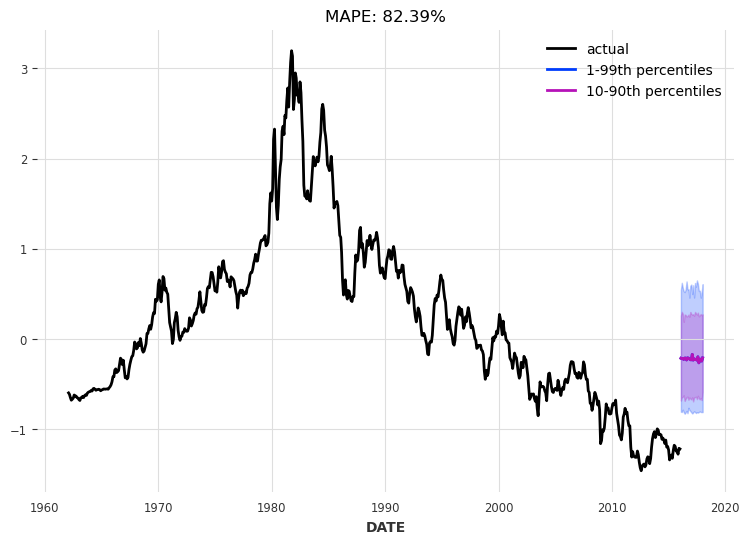

In [10]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples, series=actual_series, past_covariates=covariates_scaled)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title(f"MAPE: {mape(val_series, pred_series):.2f}%")
    plt.legend()


eval_model(model, 24, train_ts_scaled, val_ts_scaled)